In [1]:
from models.classification_model import ClassifierModel # class with classifiers
from models.reduce_model import ReduceModel # class with autoencoder

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
# from plot_settings import * # plot configuration 

# ide_plot() #plot for github dark theme

import joblib
from copy import deepcopy
import seaborn as sns

# plt.rcParams['text.usetex'] = True

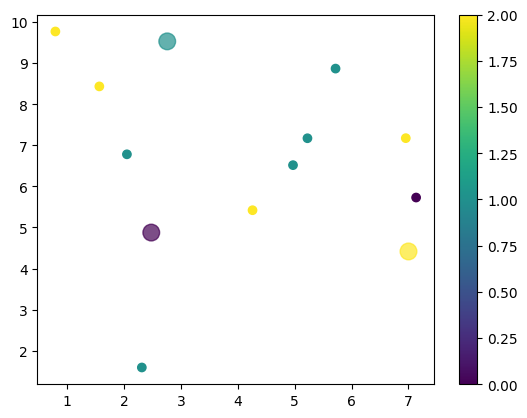

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

points = np.random.uniform(0,10, size = (10,2))

labels = np.random.randint(0,3, size = 10)

extraPoints = np.random.uniform(0,10, size = (3,2))

sc = plt.scatter(points[:,0], points[:,1], c = labels) 
sc2 = plt.scatter(extraPoints[:,0], extraPoints[:,1], s = 144, alpha = 0.7, 
            c = np.arange(len(extraPoints)))

plt.colorbar(sc)

plt.show()

In [3]:
dataset = pd.read_csv("preprocessing/datasets/main_dataset.csv", index_col=0)
target = pd.read_csv("preprocessing/datasets/main_target.csv", index_col=0)

In [4]:
reduce_model = joblib.load("best/reduce_model.pkl")
c_model = joblib.load("best/c_model.pkl")

In [5]:
main_reduced = reduce_model.transform(dataset)

In [29]:
def clf_per_seed(n=10, metric = ClassifierModel.score):
    clfs = deepcopy(c_model)
    result = {name: [0.]*n for name in clfs.models}
    result["Median"] = [0.]*n
    for seed in range(0, n):
        X_train, X_test, y_train, y_test = train_test_split(
        main_reduced, target.values.ravel(), test_size=0.2, random_state=seed,
        #stratify=target.values.ravel()
        )
        scaler = RobustScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        for clf in clfs.models:
            clfs.models[clf].fit(X_train, y_train)
            result[clf][seed] = metric(y_test, clfs.models[clf].predict(X_test))
        result["Median"][seed] = metric(y_test, np.ones_like(y_test)*np.median(y_test))
    
    
    return result





    

In [30]:
r = pd.DataFrame(clf_per_seed(100))
print(r.mean())
print(r.std())

CatBoost    0.629374
RF          0.653003
AdaBoost    0.589506
Knn         0.701686
Median      0.296543
dtype: float64
CatBoost    0.122461
RF          0.115892
AdaBoost    0.115028
Knn         0.109775
Median      0.034746
dtype: float64


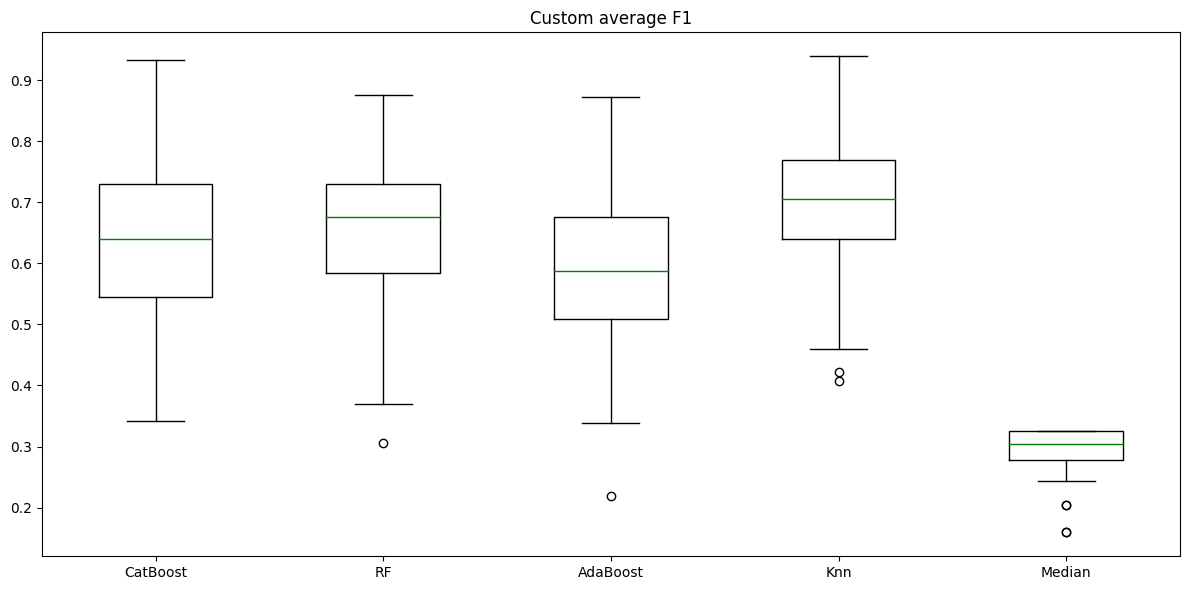

In [31]:
plt.figure(figsize=(12, 6))
plt.boxplot(r.values, labels=r.columns,
            boxprops=dict(color="k"),
            capprops=dict(color="k"),
            whiskerprops=dict(color="k"),
            medianprops=dict(color="g"),
            flierprops=dict(color="k", markeredgecolor="k"),
            )



plt.title("Custom F1")
plt.tight_layout()
plt.show()

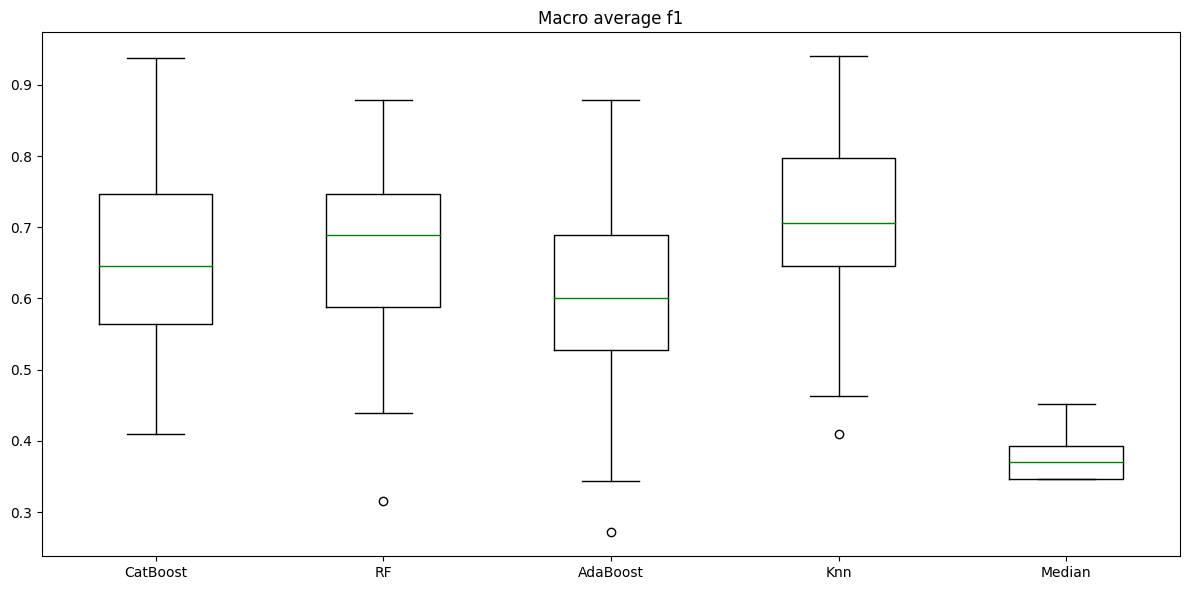

In [33]:
r = pd.DataFrame(clf_per_seed(100, lambda y_t, y_p: metrics.f1_score(y_t, y_p, average="macro")))
plt.figure(figsize=(12, 6))
plt.boxplot(r.values, labels=r.columns,
            boxprops=dict(color="k"),
            capprops=dict(color="k"),
            whiskerprops=dict(color="k"),
            medianprops=dict(color="g"),
            flierprops=dict(color="k", markeredgecolor="k"),
            )
plt.title("Macro average f1")
plt.tight_layout()
plt.show()

In [34]:
print(r.mean())
print(r.std())

CatBoost    0.645167
RF          0.666170
AdaBoost    0.606385
Knn         0.714905
Median      0.372959
dtype: float64
CatBoost    0.114165
RF          0.110671
AdaBoost    0.105694
Knn         0.105159
Median      0.026124
dtype: float64


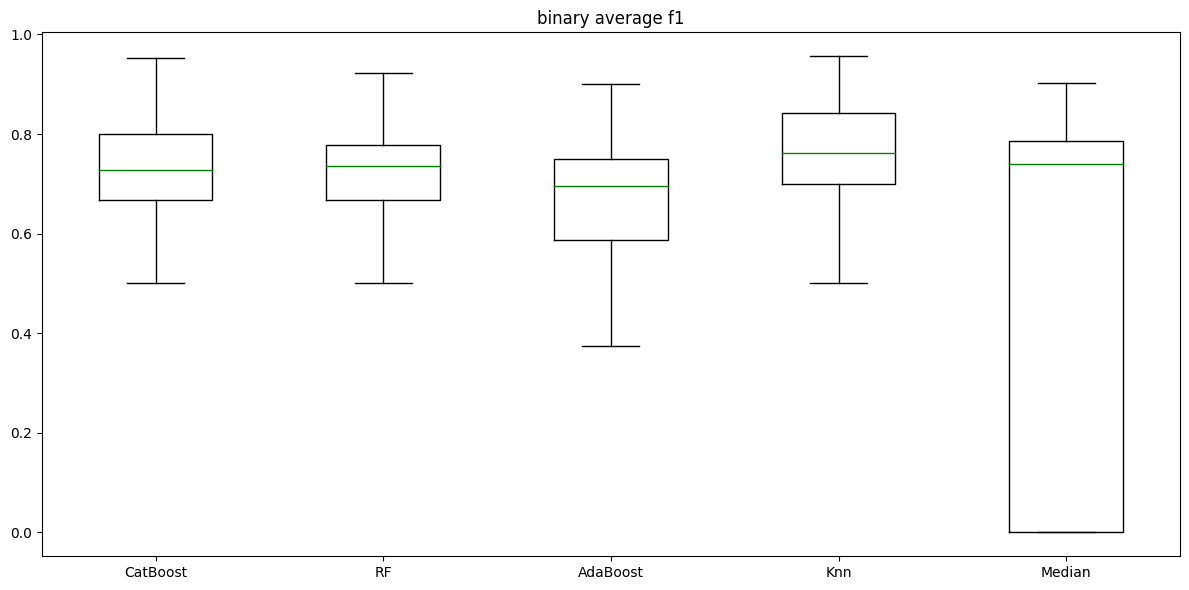

In [37]:
r = pd.DataFrame(clf_per_seed(100, lambda y_t, y_p: metrics.f1_score(y_t, y_p, pos_label=1)))
plt.figure(figsize=(12, 6))
plt.boxplot(r.values, labels=r.columns,
            boxprops=dict(color="k"),
            capprops=dict(color="k"),
            whiskerprops=dict(color="k"),
            medianprops=dict(color="g"),
            flierprops=dict(color="k", markeredgecolor="w"),
            )
plt.title("binary average f1")
plt.tight_layout()
plt.show()

In [11]:
def roc_auc_plot(ax, clf_model: ClassifierModel, x_test, y_test):
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    lw = 2
    ax.plot()
    for clf in clf_model.models:
        pred_proba = clf_model.models[clf].predict_proba(x_test)
        fpr, tpr, threshold = metrics.roc_curve(y_test, pred_proba[:,1])
        auc = metrics.auc(fpr, tpr)
        ax.plot(fpr,
                 tpr,
                 linestyle='--',
                 label=f"ROC curve {clf} (area={auc:.2f})")
    
    ax.plot([0, 1], [0, 1], color="purple", lw=lw, linestyle="--")
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel("False Positive Rate", size=15)
    ax.set_ylabel("True Positive Rate", size=15)
    #ax.set_title("Receiver operating characteristic example", size=15)
    ax.legend(loc="lower right", fontsize=15)
    ax.tick_params(axis='both',label1On=True, size=5, labelsize=15)
    # plt.show()


In [39]:
def roc_auc_per_seed(n=10):
    clfs = deepcopy(c_model)
    result = {name: [0.]*n for name in clfs.models}
    for seed in range(0, n):
        X_train, X_test, y_train, y_test = train_test_split(
            main_reduced, target.values.ravel(), test_size=0.2, random_state=seed,
            #stratify=target.values.ravel()
            )
        scaler = RobustScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        for clf in clfs.models:
            clfs.models[clf].fit(X_train, y_train)
            pred_proba = clfs.models[clf].predict_proba(X_test)
            fpr, tpr, threshold = metrics.roc_curve(y_test, pred_proba[:,1])
            auc = metrics.auc(fpr, tpr)
            result[clf][seed] = auc

    return result

CatBoost    0.790908
RF          0.777430
AdaBoost    0.664699
Knn         0.811011
dtype: float64
CatBoost    0.106192
RF          0.104797
AdaBoost    0.120674
Knn         0.100566
dtype: float64


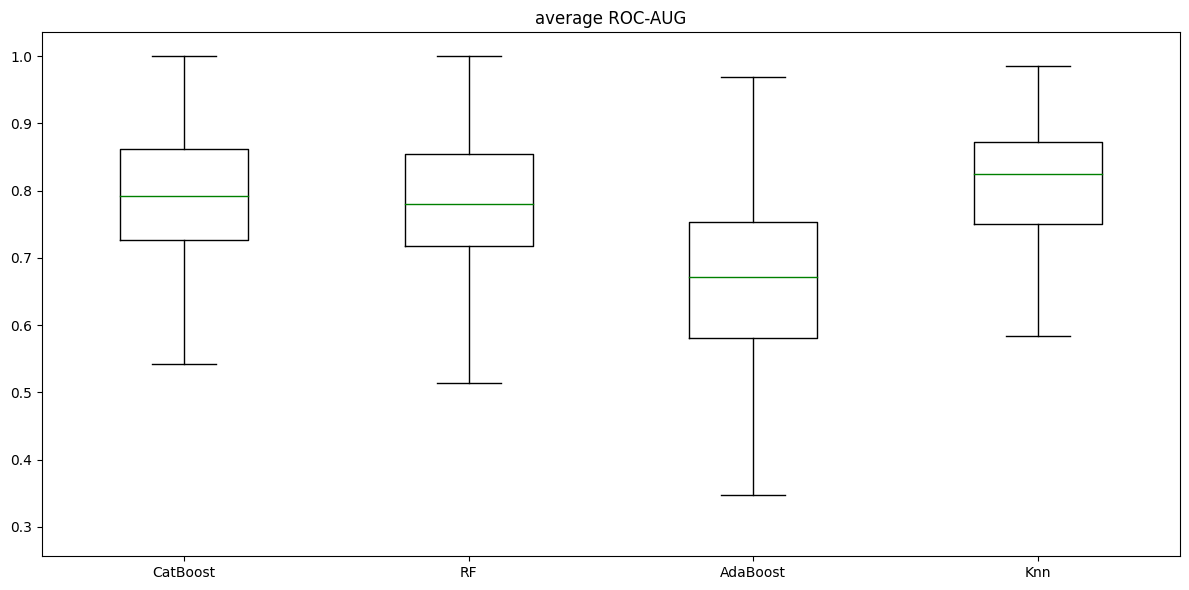

In [40]:
r = pd.DataFrame(roc_auc_per_seed(100))
print(r.mean())
print(r.std())
plt.figure(figsize=(12, 6))
plt.boxplot(r.values, labels=r.columns,
            boxprops=dict(color="k"),
            capprops=dict(color="k"),
            whiskerprops=dict(color="k"),
            medianprops=dict(color="g"),
            flierprops=dict(color="k", markeredgecolor="w"),
            )
plt.title("average ROC-AUG")
plt.tight_layout()
plt.show()

In [13]:
def clf_per_ls_dim(dim):
    reduce_model = ReduceModel(model="AE", layers=(1169, 500, 200, dim))
    reduce_model.train(epochs=60, lr=1e-3)

    main_reduced = reduce_model.transform(dataset)

    X_train, X_test, y_train, y_test = train_test_split(
    main_reduced, target.values.ravel(), test_size=0.2, random_state=0,
    #stratify=target.values.ravel()
    )

    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    c_model = ClassifierModel()
    res = c_model.cv(pd.DataFrame(X_train), pd.DataFrame(y_train), time_per_clf=10)
    c_model.set_params({name: {param: res[name][param] for param in res[name] if param not in (
    "balance", "score")} for name in res})
    c_model.fit(X_train, y_train)
    res = {"model": deepcopy(c_model),
                "data": [X_train, X_test, y_train, y_test]}
    for name in c_model.models:
        pred = c_model.models[name].predict(X_test)
        print(f"report for {name}: {c_model.score(y_test, pred):.2f}")
        print(metrics.classification_report(y_test, pred))
    return res

In [14]:
store = {i: clf_per_ls_dim(i) for i in [40, 30, 20, 10, 8, 6, 5, 2]}


TypeError: AE.__init__() got an unexpected keyword argument 'model'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    main_reduced, target.values.ravel(), test_size=0.2, random_state=0,
    #stratify=target.values.ravel()
    )

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

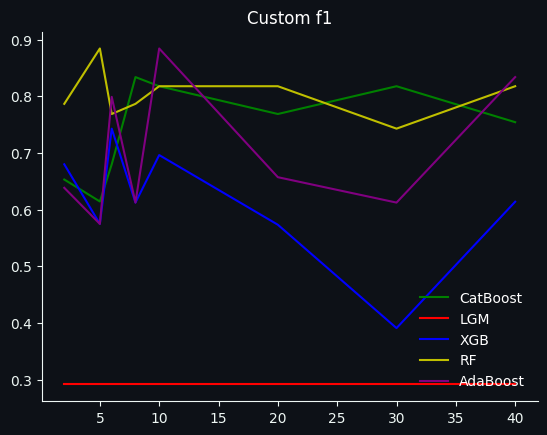

In [ ]:
for name in ClassifierModel.clf_dict.keys():
    plt.plot(store.keys(), [ClassifierModel.score(store[dim]["data"][3], store[dim]["model"].models[name].predict(store[dim]["data"][1])) for dim in store.keys()], label=name)

plt.legend()
plt.title("Custom f1")
plt.show()


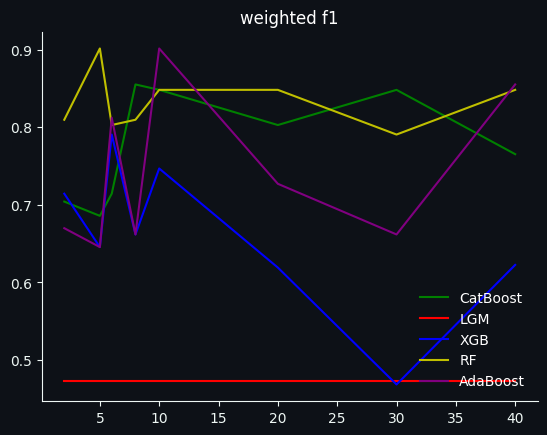

In [ ]:
for name in ClassifierModel.clf_dict.keys():
    plt.plot(store.keys(), [metrics.f1_score(store[dim]["data"][3], store[dim]["model"].models[name].predict(store[dim]["data"][1]), average="weighted") for dim in store.keys()], label=name)

plt.legend()
plt.title("weighted f1")
plt.show()